In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8

            nn.Flatten(),
            nn.Linear(256*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_loss = []
epochs = 70

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_loss.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    scheduler.step()


Epoch 1/70, Loss: 2.3185
Epoch 2/70, Loss: 2.1998
Epoch 3/70, Loss: 1.8813
Epoch 4/70, Loss: 1.7342
Epoch 5/70, Loss: 1.6322
Epoch 6/70, Loss: 1.5783
Epoch 7/70, Loss: 1.5345
Epoch 8/70, Loss: 1.5031
Epoch 9/70, Loss: 1.4746
Epoch 10/70, Loss: 1.4414
Epoch 11/70, Loss: 1.3705
Epoch 12/70, Loss: 1.3458
Epoch 13/70, Loss: 1.3144
Epoch 14/70, Loss: 1.3052
Epoch 15/70, Loss: 1.2787
Epoch 16/70, Loss: 1.2404
Epoch 17/70, Loss: 1.2010
Epoch 18/70, Loss: 1.1619
Epoch 19/70, Loss: 1.1351
Epoch 20/70, Loss: 1.1031
Epoch 21/70, Loss: 1.0547
Epoch 22/70, Loss: 1.0299
Epoch 23/70, Loss: 1.0202
Epoch 24/70, Loss: 1.0054
Epoch 25/70, Loss: 0.9929
Epoch 26/70, Loss: 0.9757
Epoch 27/70, Loss: 0.9678
Epoch 28/70, Loss: 0.9582
Epoch 29/70, Loss: 0.9500
Epoch 30/70, Loss: 0.9461
Epoch 31/70, Loss: 0.9084
Epoch 32/70, Loss: 0.9025
Epoch 33/70, Loss: 0.9011
Epoch 34/70, Loss: 0.8850
Epoch 35/70, Loss: 0.8884
Epoch 36/70, Loss: 0.8701
Epoch 37/70, Loss: 0.8572
Epoch 38/70, Loss: 0.8459
Epoch 39/70, Loss: 0.

In [11]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 74.12%


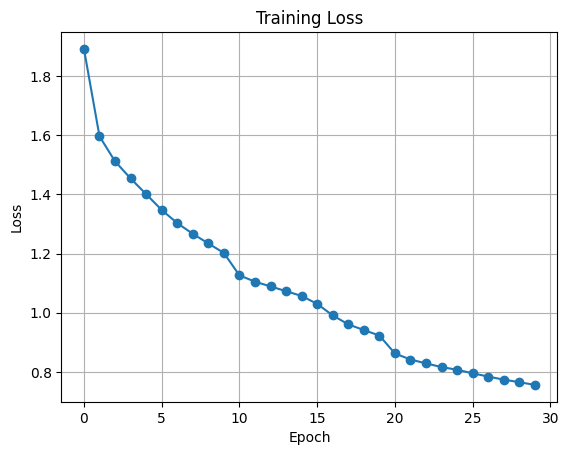

In [12]:
plt.plot(range(epochs), train_loss, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
